<a href="https://colab.research.google.com/github/azastron/ML_NeuralNetworks/blob/main/HW5_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classify Cells

This is the third task of Homework 5 of Andreas Muller course on Applied Machine Learning offered at Columbia during the Spring 2020 semester.

Train a convolutional neural network on the following dataset:
https://lhncbc.nlm.nih.gov/publication/pub9932

The goal is to classify cells infected with malaria against those that are not.

3.1 Start with a convolutional model without residual connections (using batch normalization is likely to be helpful and you should try it, whether you use dropout is your choice).

3.2 Augment the data using rotations, mirroring and possibly other transformations. How much
can you improve your original model by data augmentation?

3.3 Build a deeper model using residual connections. Show that you can build a deep model
that would not be able to learn if you remove the residual connections (i.e. compare a deep
model with and without residual connections while the rest of the architecture is constant).
Feel free to reuse existing architectures from the literature or use them as inspiration for your
own. You can find commonly used architectures here:
https://keras.io/applications/

However, the point of the exercise is to learn the weights from scratch, so please do not reuse
the weights shipped with these applications.

3.4 BONUS / Optional: Transfer learning
Reuse an existing architecture and pre-trained weights from keras
( https://keras.io/applications/ ). Compare retraining only the densely connected layers with
fine-tuning the whole network.

Hint : Make sure you are doing the reshape for the training set correctly. A direct reshape might
give you garbled images. Display an image after reshaping to make sure they are correct.

In [1]:
!mkdir .kaggle
!mkdir ~/.kaggle

In [2]:
import json

token = {"username":"azastron", "key":"b2f424681d6a7911e537361a10303955"}

In [3]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [4]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [5]:
#configure the file
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!kaggle datasets list -s sentiment

ref                                                      title                                             size  lastUpdated          downloadCount  
-------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  
crowdflower/twitter-airline-sentiment                    Twitter US Airline Sentiment                       3MB  2019-10-16 00:04:05          47825  
harriken/emoji-sentiment                                 Emoji sentiment                                   12MB  2017-10-01 09:56:54           2671  
kazanova/sentiment140                                    Sentiment140 dataset with 1.6 million tweets      81MB  2017-09-13 22:43:19          44284  
yash612/stockmarket-sentiment-dataset                    Stock-Market Sentiment Dataset                   201KB  2020-06-05 19:16:19           1865  
bittlingmayer/amazonreviews                              Amazon Reviews for Sentiment Analysis      

In [7]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p /content

 97% 657M/675M [00:07<00:00, 98.4MB/s]
100% 675M/675M [00:08<00:00, 87.7MB/s]


In [8]:
import os
import zipfile

local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/cell-images-for-detecting-malaria')
zip_ref.close()

Learning about dataset!

In [9]:
# Directory with our training unifected pictures
uninfected_dir = os.path.join('/content/cell-images-for-detecting-malaria/cell_images/Uninfected')
# Directory with our training infected or parasitized pictures
infected_dir = os.path.join('/content/cell-images-for-detecting-malaria/cell_images/Parasitized')
print(len(os.listdir(infected_dir)))
print(len(os.listdir(uninfected_dir)))

13780
13780


In [11]:
try:
    os.mkdir('/content/cell-images-for-detecting-malaria/cell_images/training')
    os.mkdir('/content/cell-images-for-detecting-malaria/cell_images/testing')

    os.mkdir('/content/cell-images-for-detecting-malaria/cell_images/training/uninfected')
    os.mkdir('/content/cell-images-for-detecting-malaria/cell_images/training/infected')

    os.mkdir('/content/cell-images-for-detecting-malaria/cell_images/testing/uninfected')
    os.mkdir('/content/cell-images-for-detecting-malaria/cell_images/testing/infected')
except OSError as e:

    print('error:', e)

error: [Errno 17] File exists: '/content/cell-images-for-detecting-malaria/cell_images/training'


In [12]:
INFECTED_SOURCE_DIR = "/content/cell-images-for-detecting-malaria/cell_images/Parasitized/"
TRAINING_INFECTED_DIR = "/content/cell-images-for-detecting-malaria/cell_images/training/infected/"
TESTING_INFECTED_DIR = "/content/cell-images-for-detecting-malaria/cell_images/testing/infected/"

UNINFECTED_SOURCE_DIR = "/content/cell-images-for-detecting-malaria/cell_images/Uninfected/"
TRAINING_UNINFECTED_DIR = "/content/cell-images-for-detecting-malaria/cell_images/training/uninfected/"
TESTING_UNINFECTED_DIR = "/content/cell-images-for-detecting-malaria/cell_images/testing/uninfected/"


In [13]:
import random 
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

split_size = .9
split_data(INFECTED_SOURCE_DIR, TRAINING_INFECTED_DIR, TESTING_INFECTED_DIR, split_size)
split_data(UNINFECTED_SOURCE_DIR, TRAINING_UNINFECTED_DIR, TESTING_UNINFECTED_DIR, split_size)

In [14]:
train_infected_names = os.listdir(TRAINING_INFECTED_DIR)
print(train_infected_names[:10])

train_uninfected_names = os.listdir(TRAINING_UNINFECTED_DIR)
print(train_uninfected_names[:10])

['C149P110ThinF_IMG_20151115_114910_cell_290.png', 'C137P98ThinF_IMG_20151005_163712_cell_89.png', 'C189P150ThinF_IMG_20151203_142113_cell_80.png', 'C68P29N_ThinF_IMG_20150819_134830_cell_75.png', 'C186P147NThinF_IMG_20151203_150557_cell_177.png', 'C173P134NThinF_IMG_20151130_115733_cell_228.png', 'C181P142ThinF_IMG_20151127_155722_cell_175.png', 'C134P95ThinF_IMG_20151005_121048_cell_113.png', 'C48P9thinF_IMG_20150721_163810_cell_15.png', 'C130P91ThinF_IMG_20151004_142709_cell_121.png']
['C174P135NThinF_IMG_20151127_135554_cell_84.png', 'C222ThinF_IMG_20151115_151015_cell_174.png', 'C142P103ThinF_IMG_20151005_222440_cell_6.png', 'C46P7ThinF_IMG_20151130_210743_cell_47.png', 'C147P108ThinF_IMG_20151115_092900_cell_145.png', 'C232ThinF_IMG_20151112_154345_cell_233.png', 'C217ThinF_IMG_20151106_141135_cell_38.png', 'C123P84ThinF_IMG_20151002_151851_cell_58.png', 'C142P103ThinF_IMG_20151005_222440_cell_85.png', 'C162P123ThinF_IMG_20151116_102751_cell_107.png']


In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4

pic_index = 0

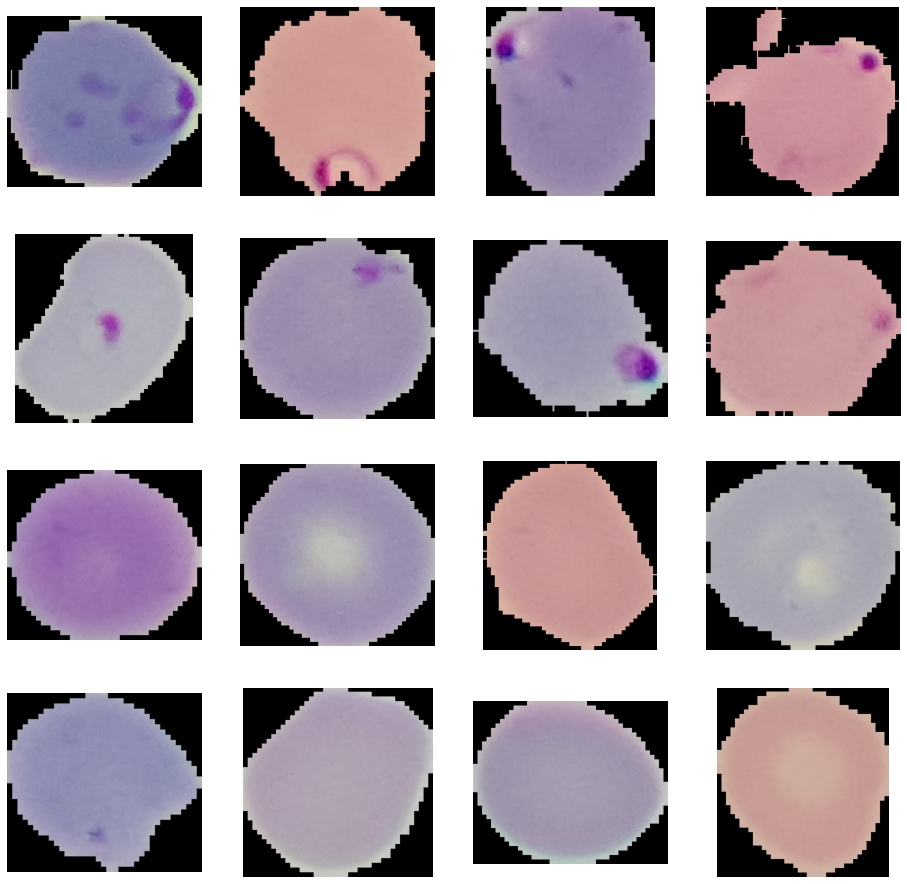

In [16]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_infected_pix = [os.path.join(TRAINING_INFECTED_DIR, 
fname) for fname in train_infected_names[pic_index-8:pic_index]]
next_uninfected_pix = [os.path.join(TRAINING_UNINFECTED_DIR, fname) for fname in train_uninfected_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_infected_pix+next_uninfected_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator

3.1 A convolutional network with batch normalization and dropout, but without residual connections.

In [18]:
cnn = Sequential()

cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(80, 80, 3)))
cnn.add(MaxPooling2D(2, 2))

cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(2, 2))

cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(2, 2))

cnn.add(Flatten())

cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))



In [19]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [20]:
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
training_directory = '/content/cell-images-for-detecting-malaria/cell_images/training/'
train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        training_directory,
        target_size=(80, 80),
        batch_size=256,
        class_mode='binary')

Found 24802 images belonging to 2 classes.


In [25]:
history = cnn.fit(
      train_generator,
      steps_per_epoch=96,  
      epochs=15,
      verbose=1)

Epoch 1/15
96/96 [==============================] - 21s 222ms/step - loss: 0.2540 - accuracy: 0.9010
Epoch 2/15
96/96 [==============================] - 21s 221ms/step - loss: 0.1683 - accuracy: 0.9426
Epoch 3/15
96/96 [==============================] - 21s 222ms/step - loss: 0.1481 - accuracy: 0.9502
Epoch 4/15
96/96 [==============================] - 21s 222ms/step - loss: 0.1336 - accuracy: 0.9541
Epoch 5/15
96/96 [==============================] - 21s 220ms/step - loss: 0.1270 - accuracy: 0.9565
Epoch 6/15
96/96 [==============================] - 21s 220ms/step - loss: 0.1170 - accuracy: 0.9613
Epoch 7/15
96/96 [==============================] - 21s 221ms/step - loss: 0.1079 - accuracy: 0.9630
Epoch 8/15
96/96 [==============================] - 21s 221ms/step - loss: 0.1018 - accuracy: 0.9654
Epoch 9/15
96/96 [==============================] - 21s 221ms/step - loss: 0.0950 - accuracy: 0.9681
Epoch 10/15
96/96 [==============================] - 21s 220ms/step - loss: 0.0893 - accura

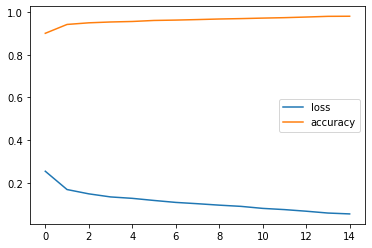

In [26]:
pd.DataFrame(history.history).plot()

Data Augmentation

In [32]:
datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

train_generator_aug = datagen.flow_from_directory(
        training_directory,
        target_size=(80, 80),
        batch_size=256,
        class_mode='binary')


Found 24802 images belonging to 2 classes.


In [33]:
history_aug = cnn.fit(
      train_generator_aug,
      steps_per_epoch=96,  
      epochs=15,
      verbose=1)

Epoch 1/15
96/96 [==============================] - 53s 548ms/step - loss: 0.4485 - accuracy: 0.8209
Epoch 2/15
96/96 [==============================] - 52s 545ms/step - loss: 0.3696 - accuracy: 0.8595
Epoch 3/15
96/96 [==============================] - 52s 545ms/step - loss: 0.3378 - accuracy: 0.8697
Epoch 4/15
96/96 [==============================] - 52s 546ms/step - loss: 0.3159 - accuracy: 0.8802
Epoch 5/15
96/96 [==============================] - 52s 544ms/step - loss: 0.2972 - accuracy: 0.8867
Epoch 6/15
96/96 [==============================] - 52s 545ms/step - loss: 0.2884 - accuracy: 0.8906
Epoch 7/15
96/96 [==============================] - 52s 546ms/step - loss: 0.2806 - accuracy: 0.8948
Epoch 8/15
96/96 [==============================] - 52s 544ms/step - loss: 0.2715 - accuracy: 0.9000
Epoch 9/15
96/96 [==============================] - 52s 545ms/step - loss: 0.2788 - accuracy: 0.8995
Epoch 10/15
96/96 [==============================] - 53s 548ms/step - loss: 0.2637 - accura